![](figs/se05.png)
# Workshop Instructions
***
- <img src="figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> Follow along by typing the code yourself - this helps with learning!
- <img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> Code cells marked as "Exercise" are for you to complete
- <img src="figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(1500%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> Look for hints if you get stuck
- <img src="figs/icons/success.svg" width="20" style="filter: invert(56%) sepia(71%) saturate(5293%) hue-rotate(117deg) brightness(95%) contrast(101%);"/> Compare your solution with the provided answers
- <img src="figs/icons/list.svg" width="20" style="filter: invert(19%) sepia(75%) saturate(6158%) hue-rotate(312deg) brightness(87%) contrast(116%);"/> Don't worry if you make mistakes - debugging is part of learning!

In [ ]:
from pathlib import Path
import sys

helper_utils = Path.cwd() / "utils"
sys.path.append(str(helper_utils))

import utils
from torchvision import transforms
from PIL import Image
import random
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
torch.manual_seed(101)
torch.cuda.manual_seed(101)
random.seed(101)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

checker = utils.core.ExerciseChecker("SE05")
quizzer = utils.core.QuizManager("SE05")

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Introduction to Transfer Learning
***
> <img src="figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> **Definition**: Transfer learning is a machine learning technique where a model developed for one task is reused as a starting point for a model on a second task. It's particularly effective for deep learning models, as it allows us to leverage pre-trained models' knowledge rather than starting from scratch.

In previous sessions, we learned how to build and train neural networks from scratch. However, training large deep learning models requires:

1. **Massive datasets** (often millions of examples)
2. **Extensive computational resources** (often multiple GPUs)
3. **Long training times** (days to weeks)

Transfer learning addresses these challenges by letting us capitalise on existing models that have already been trained on large datasets.

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <!-- Suggestion: Create and add an image showing transfer learning concept with knowledge flowing from source to target domain -->
    <img src="figs/transfer.png" alt="Transfer Learning Concept" style="width: 50%; height: auto; margin: 0 auto;">
</figure>

Transfer learning is inspired by human learning. Consider how we learn:

| Human Learning | Machine Learning Parallel |
|----------------|--------------------------|
| A child learns to recognize basic shapes before identifying letters | A model learns edge detection before specific object recognition |
| A musician who knows piano can learn guitar faster than a novice | A model trained on one image dataset can adapt quickly to a similar task |
| Language skills transfer across related languages (e.g., Spanish to Italian) | NLP models pre-trained on one language can be fine-tuned for another |

This mirrors how neural networks learn hierarchical features. Early layers learn general patterns that are often applicable across domains, while later layers learn task-specific features.

Transfer learning is particularly effective in computer vision and natural language processing (NLP) tasks, where large pre-trained models are available. The key advntages of transfer learning include:

| Advantage | Description |
|-----------|-------------|
| **Reduced Training Time** | Start with pre-learned features instead of random weights |
| **Less Training Data** | Leverage knowledge from the source domain |
| **Better Performance** | Often achieves higher accuracy than training from scratch |
| **Faster Convergence** | Models typically reach optimal performance in fewer epochs |
| **Lower Computational Cost** | Requires fewer resources for training |
| **Knowledge Retention** | Preserves useful features learned from large datasets |

## 1.2 When to Use Transfer Learning
***

Transfer learning is particularly useful when:

1. You have **limited training data** for your specific task
2. The pre-trained model was trained on a **similar domain** to your target task
3. You need to **accelerate model development**
4. You have **limited computational resources**
5. You want to **avoid overfitting** on small datasets

> <img src="figs/icons/reminder.svg" width="20" style="filter: invert(100%) sepia(1500%) saturate(1500%) hue-rotate(30deg) brightness(450%) contrast(70%);"/> **Key Insight**: The effectiveness of transfer learning depends on the similarity between the source and target domains. The more similar they are, the more beneficial transfer learning becomes.




In [ ]:
# Quiz on Transfer Learning Concepts
print("\n🧠 Quiz 1: Transfer Learning Applications")
quizzer.run_quiz(1)

## 2. Case Study: Image Segmentation for Medical Imaging
***
> <img src="figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> **Image Segmentation**: The process of partitioning an image into multiple segments or regions, often used in medical imaging to identify and delineate structures within images (e.g., tumors, organs). It is a crucial step in many computer vision tasks, including object detection and recognition.

For this session, we are going to be using the [**ISIC 2016 Skin Lesion Segmentation Challenge**](https://challenge.isic-archive.com/landing/2016/) dataset. This dataset contains dermoscopic images of skin lesions, along with their corresponding segmentation masks. The goal is to train a model to accurately segment the lesions from the background.

In [ ]:
data_path = Path(Path.cwd(), 'datasets')
dataset_path = utils.data.download_dataset('skin lessions',
                                           dest_path=data_path,
                                           extract=True,
                                           remove_compressed=False)
mask_path = utils.data.download_dataset('skin lessions masks',
                                   dest_path=data_path,
                                   extract=True,
                                   remove_compressed=False)

## 2.1 Preparing the Dataset
***
Segmentation tasks require both the input images and their corresponding masks. The masks are binary images where the pixels belonging to the object of interest (e.g., a tumor) are marked as 1 (or white), while the background is marked as 0 (or black). Thus, we need to load both the images and their masks for training.

In order for us to efficiently load the images and masks, we are going to create a custom dataset class. This class will inherit from the `torch.utils.data.Dataset` class and will handle loading the images and masks from the specified directories.

***
> <img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> **Snippet 1**: Create a custom dataset class for loading

``` python
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, **kwargs):
        """
        Initializes the dataset, loading the images and masks from the specified directories.
        """
    
    def __len__(self):
        """
        Returns the number of images in the dataset.
        """
    
    def __getitem__(self, idx):
        """
        Defines how to get a single item (image and mask) from the dataset.
        
```

***
The `Dataset` class requires us to implement three methods: 
| Method | Description |
|--------|-------------|
| `__init__` | Initializes the dataset, loading the images and masks from the specified directories. |
| `__len__` | Returns the number of images in the dataset. |
| `__getitem__` | Defines how to get a single item (image and mask) from the dataset. This can include loading the image, applying transformations, and returning the image and mask as tensors. |

In [ ]:
from torch.utils.data import Dataset, DataLoader

class ISICDataset(Dataset):
    def __init__(self, image_dir: Path | str, mask_dir: Path | str, img_transform=None, mask_transform=None):
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        self.images = sorted(self.image_dir.glob("*.jpg"))
        self.masks = sorted(self.mask_dir.glob("*.png"))

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = self.image_dir / img_name
        mask_name = str(img_name.stem + "_segmentation.png")
        mask_path = self.mask_dir / mask_name

        image = Image.open(img_path).convert("RGB") # Convert to RGB
        mask = Image.open(mask_path).convert("L") # Convert to grayscale since it's a binary mask

        # Apply transformations if provided
        if self.img_transform:
            image = self.img_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        return image, mask

## 2.2 Compute the Mean and Standard Deviation of the Dataset
***

We are going to compute the mean and standard deviation of the dataset. This is important because we will use these values to normalize the images before feeding them into the model. Normalization helps in speeding up the convergence of the model during training.

First, we need to load the dataset and then compute the mean and standard deviation. 

In [ ]:
from tqdm import tqdm

imgs_path = list(dataset_path.glob("*"))[0]
masks_path = list(mask_path.glob("*"))[0]

resize_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

ds = ISICDataset(
    image_dir=imgs_path,
    mask_dir=masks_path,
    img_transform=resize_transform,
    mask_transform=resize_transform
)

dl = DataLoader(ds, batch_size=16, shuffle=False)

mean = 0.0
std = 0.0
n_samples = 0.0

for data, _ in tqdm(dl, desc="Computing mean and std", bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}'):
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    n_samples += batch_samples

mean /= n_samples
std /= n_samples

print("\nMean:", mean.numpy())
print("Std:", std.numpy())



## 2.3 Data Augmentation
***
As we saw in the previous sessions, data augmentation is a technique used to artificially increase the size of the training dataset by applying random transformations to the images. This helps in improving the generalization of the model and reducing overfitting. 

We are going to use the albumentations library for data augmentation. This library outperforms the torchvision library in terms of speed and flexibility. It provides the same transformations as torchvision and it is also compatible with PyTorch.

***
> <img src="figs/icons/code.svg" width="20" style="filter: invert(100%) sepia(100%) saturate(2000%) hue-rotate(40deg) brightness(915%) contrast(100%);"/> **Snippet 2**: Using albumentations for data augmentation

``` python
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=mean, std=std, p=1.0),
    ToTensorV2()
])
```

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_img_ts = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=10,p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.Normalize(mean=mean.numpy(), std=std.numpy(), p=1.0),
    ToTensorV2()
])

valid_img_ts = A.Compose([
    A.Resize(128, 128),
    A.Normalize(mean=mean.numpy(), std=std.numpy(), p=1.0),
    ToTensorV2()
])


In [ ]:
# Redifine the dataset with albumentations
class ISICDatasetAlbumentations(ISICDataset):
    def __init__(self, image_dir: Path | str, mask_dir: Path | str, transform=None):
        super().__init__(image_dir, mask_dir, transform, None)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = self.image_dir / img_name
        mask_name = str(img_name.stem + "_segmentation.png")
        mask_path = self.mask_dir / mask_name

        image = Image.open(img_path).convert("RGB") # Convert to RGB
        image = np.array(image)  # Convert to numpy array for albumentations
        mask = Image.open(mask_path).convert("L") # Convert to grayscale since it's a binary mask
        mask = np.array(mask)

        # Normalize mask to 0-1 range if it's not already
        if mask.max() > 1:
            mask = mask / 255.0

        # Apply transformations if provided
        if self.img_transform:
            aug = self.img_transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']
            
            # Ensure mask is binary (0 or 1)
            if isinstance(mask, torch.Tensor):
                mask = (mask > 0.5).float()

        return image, mask

In [ ]:
full_ds = ISICDatasetAlbumentations(
    image_dir=imgs_path,
    mask_dir=masks_path,
    transform=train_img_ts
)

train_size = int(0.8 * len(full_ds))
valid_size = len(full_ds) - train_size
train_ds, valid_ds = torch.utils.data.random_split(full_ds, [train_size, valid_size])

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=16, shuffle=False)

In [ ]:
def show_batch(dl, n=4):
    """Show a batch of images and masks."""
    for images, masks in dl:
        fig, ax = plt.subplots(nrows=2, ncols=n, figsize=(20, 5))
        for i in range(n):
            # Denormalize the image
            img = images[i].permute(1, 2, 0).numpy()
            img = img * std.numpy() + mean.numpy()
            img = np.clip(img, 0, 1)  # Clip values to valid range
            
            ax[0, i].imshow(img)
            ax[0, i].set_title(f"Image {i+1}")
            ax[0, i].axis('off')
            ax[1, i].imshow(masks[i].squeeze(), cmap='gray')
            ax[1, i].set_title(f"Mask {i+1}")
            ax[1, i].axis('off')
        plt.show()
        break

show_batch(train_dl, n=4)

# 3. Baseline Model U-Net
***
> <img src="figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> **U-Net**: A convolutional neural network architecture designed for biomedical image segmentation. It consists of a contracting path (encoder) and an expansive path (decoder), allowing it to capture both context and localization information.

The U-Net architecture is widely used in medical image segmentation tasks due to its ability to learn both local and global features. The architecture can is shown below:

<figure style="background-color: white; border-radius: 10px; padding: 20px; text-align: center; margin: 0 auto;">
    <img src="figs/unet.png" alt="U-Net Architecture" style="width: 50%; height: auto; margin: 0 auto;">
</figure>

The U-Net architecture consists of two main parts: the encoder and the decoder. The encoder captures context information, while the decoder enables precise localization. The skip connections between the encoder and decoder help retain spatial information lost during downsampling.

For this architecture we are going to use a special type of convolutional layer that upsamples the input feature maps. This layer is called a transposed convolutional layer (also known as a deconvolutional layer). It is used to increase the spatial dimensions of the input feature maps, allowing the model to learn more complex features.

We are going to implement the U-Net architecture using PyTorch. The implementation will consist of the following components:

| Component | Description |
|----------|-------------|
| `DoubleConv` | A block that consists of two convolutional layers followed by batch normalization and ReLU activation. |
| `Down` | A block that consists of a max pooling layer followed by a `DoubleConv` block. |
| `Up` | A block that consists of a transposed convolutional layer followed by a `DoubleConv` block. |
| `UNet` | The main U-Net architecture that consists of the encoder and decoder blocks. |

In [65]:
# Unet model
import torch
import torch.nn as nn

import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        # Encoder: Downsampling path
        self.encoder1 = DoubleConv(in_channels, 64)
        self.encoder2 = DoubleConv(64, 128)
        self.encoder3 = DoubleConv(128, 256)
        self.encoder4 = DoubleConv(256, 512)

        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)

        # Decoder: Upsampling path
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = DoubleConv(128, 64)

        # Output layer
        self.output_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, 2))
        enc3 = self.encoder3(F.max_pool2d(enc2, 2))
        enc4 = self.encoder4(F.max_pool2d(enc3, 2))

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))

        # Decoder with skip connections
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        # Output layer
        output = self.output_conv(dec1)
        return output


## 3.1 Segmentation Loss Function
***
While we can use a simple loss function like binary cross-entropy for segmentation tasks since we are dealing with binary masks, it is often not sufficient. This is because the model may learn to predict the background class (0) more often than the foreground class (1), leading to poor performance on the actual segmentation task.

To address this, we are going to introduce a more sophisticated loss function called the **Dice Loss**. The Dice Loss is based on the Dice coefficient, which measures the overlap between two sets. It is defined as:

$$
\text{Dice} = \frac{2 |X \cap Y|}{|X| + |Y|}$$

Where:
- \(X\) is the predicted segmentation mask
- \(Y\) is the ground truth segmentation mask
- \(|X|\) is the number of pixels in the predicted mask
- \(|Y|\) is the number of pixels in the ground truth mask
- \(|X \cap Y|\) is the number of pixels in the intersection of the predicted and ground truth masks

The Dice Loss is defined as:
$$
\text{Dice Loss} = 1 - \text{Dice}
$$

This loss function is particularly useful for imbalanced datasets, where the number of pixels in the foreground class is much smaller than the number of pixels in the background class. The Dice Loss penalizes the model more for misclassifying foreground pixels than background pixels, leading to better performance on the segmentation task.

In [66]:
class DiceLoss(torch.nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        # Ensure inputs are properly shaped
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1).float()  # Ensure mask is float type
        
        # Calculate intersection and union
        intersection = (y_pred * y_true).sum()
        union = y_pred.sum() + y_true.sum()
        
        # Calculate Dice coefficient with smoothing factor
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        
        # Return loss (1 - dice), clamped to ensure it's not negative
        return torch.clamp(1 - dice, 0.0, 1.0)

In [67]:
# Training loop
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs):
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}'):
            images = images.to(device)
            masks = masks.to(device).float()  # Ensure mask is float tensor

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Training Loss: {epoch_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in valid_loader:
                images = images.to(device)
                masks = masks.to(device).float()  # Ensure mask is float tensor

                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)

        epoch_val_loss = val_loss / len(valid_loader.dataset)
        print(f"Validation Loss: {epoch_val_loss:.4f}")
        
        # Save model if validation loss improves
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), 'best_unet_model.pt')
            print(f"Model saved. New best validation loss: {best_val_loss:.4f}")
            
        print("-" * 30)
    
    return model



In [ ]:
# Initialize the model, criterion, and optimizer

model = UNet(in_channels=3, out_channels=1).to(device)
criterion = DiceLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5
# model = train_model(model, train_dl, valid_dl, criterion, optimizer, num_epochs)

model_v1 = utils.ml.train_model(
    model=model,
    criterion=criterion,
    optimiser=optimiser,
    train_loader=train_dl,
    val_loader=valid_dl,
    num_epochs=num_epochs,
    early_stopping=True,
    patience=3,
    save_path= Path.cwd() / "my_models" / "se05_model_v1.pt",
    plot_loss=True,
)

UNet Training:   0%|          | 0/5 [00:00<?, ?it/s]

Training Batch 0/45:   0%|          | 0/45 [00:00<?, ?it/s]

Validation Batch 0/12:   0%|          | 0/12 [00:00<?, ?it/s]

Training Batch 0/45:   0%|          | 0/45 [00:00<?, ?it/s]

Validation Batch 0/12:   0%|          | 0/12 [00:00<?, ?it/s]

Training Batch 0/45:   0%|          | 0/45 [00:00<?, ?it/s]

Validation Batch 0/12:   0%|          | 0/12 [00:00<?, ?it/s]

Training Batch 0/45:   0%|          | 0/45 [00:00<?, ?it/s]

Validation Batch 0/12:   0%|          | 0/12 [00:00<?, ?it/s]

Training Batch 0/45:   0%|          | 0/45 [00:00<?, ?it/s]

Validation Batch 0/12:   0%|          | 0/12 [00:00<?, ?it/s]

Best model saved at c:\Users\Corona\Documents\Git\UoM_fse_dl_workshop\my_models\se05_model_v1.pt


Image batch shape: torch.Size([16, 3, 128, 128]), dtype: torch.float32, range: [-7.0948, 3.0340]
Mask batch shape: torch.Size([16, 128, 128]), dtype: torch.float32, range: [0.0000, 1.0000]
Unique values in mask: tensor([0., 1.])


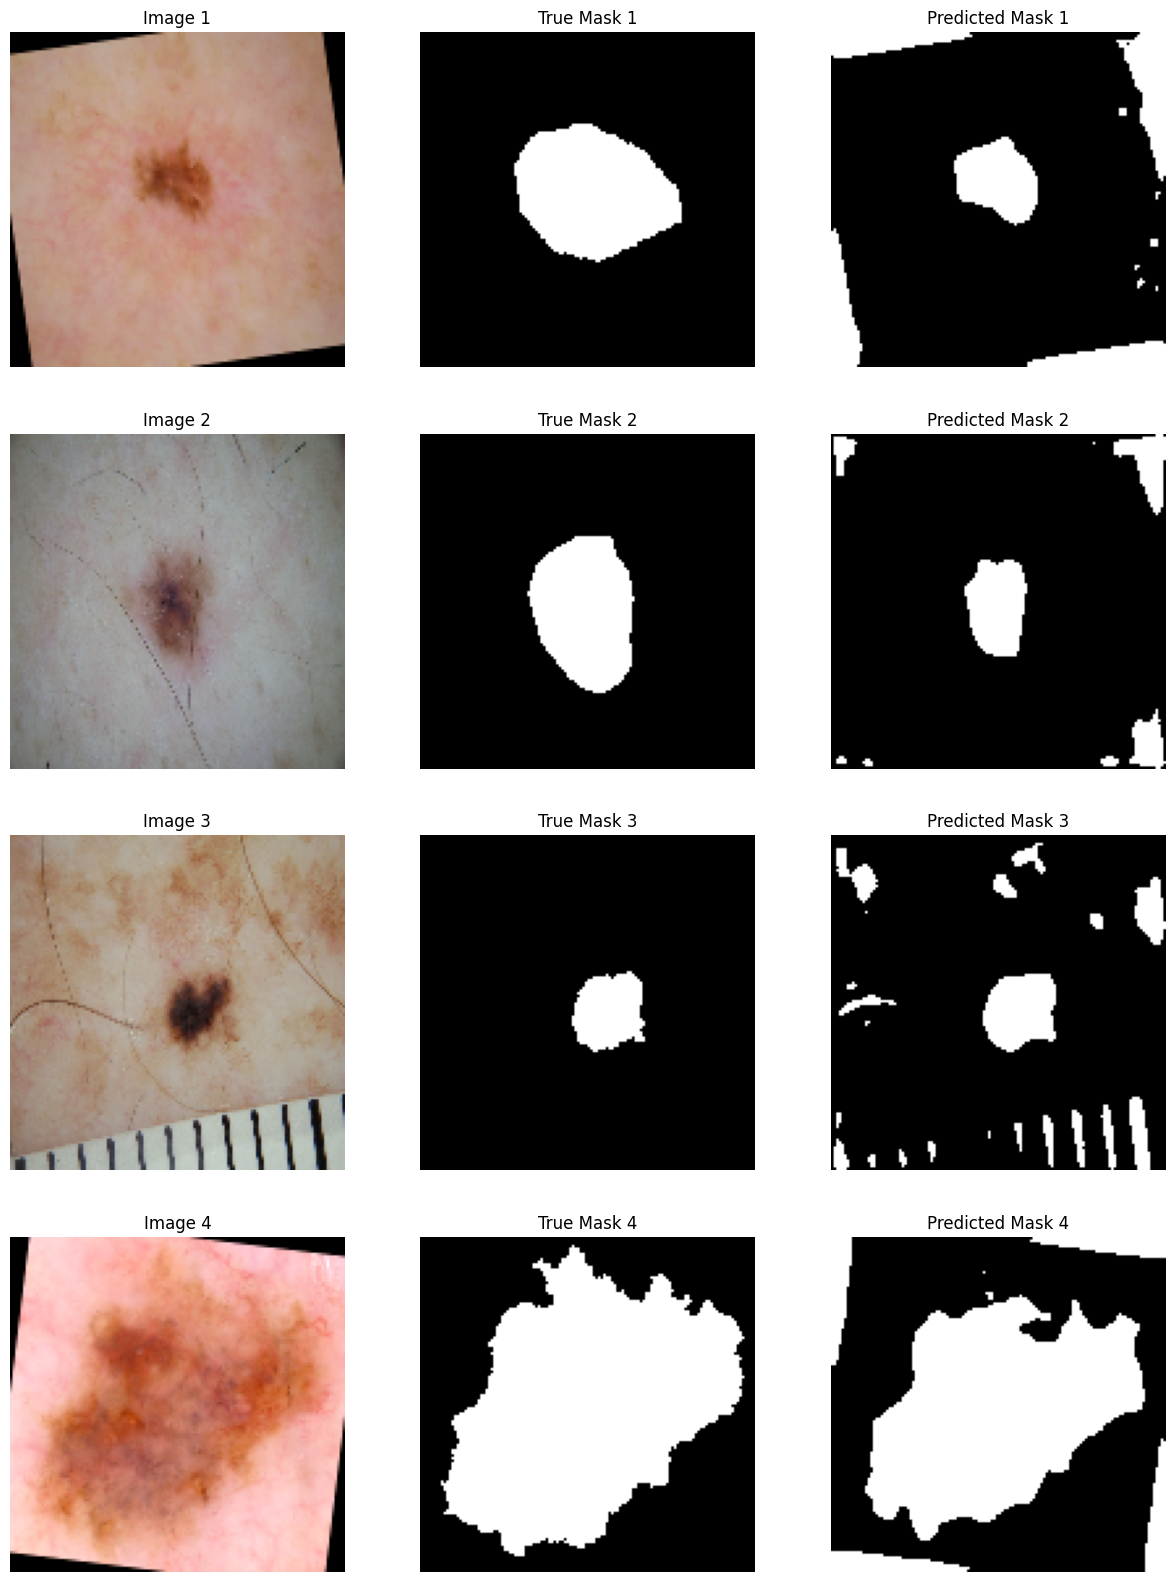

In [71]:
def visualize_predictions(model, dataloader, num_images=4):
    model.eval()
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            # Apply threshold for binary segmentation
            outputs = (outputs > 0.5).float()

            fig, ax = plt.subplots(nrows=num_images, ncols=3, figsize=(15, 5 * num_images))
            for i in range(num_images):
                # Denormalize the image
                img = images[i].cpu().permute(1, 2, 0).numpy()
                img = img * std.numpy() + mean.numpy()
                img = np.clip(img, 0, 1)  # Clip values to valid range

                ax[i, 0].imshow(img)
                ax[i, 0].set_title(f"Image {i+1}")
                ax[i, 0].axis('off')

                ax[i, 1].imshow(masks[i].squeeze().cpu().numpy(), cmap='gray')
                ax[i, 1].set_title(f"True Mask {i+1}")
                ax[i, 1].axis('off')

                ax[i, 2].imshow(outputs[i].squeeze().cpu().numpy(), cmap='gray')
                ax[i, 2].set_title(f"Predicted Mask {i+1}")
                ax[i, 2].axis('off')

            plt.show()
            break

# Add a cell to print some diagnostic information
for images, masks in valid_dl:
    print(f"Image batch shape: {images.shape}, dtype: {images.dtype}, range: [{images.min().item():.4f}, {images.max().item():.4f}]")
    print(f"Mask batch shape: {masks.shape}, dtype: {masks.dtype}, range: [{masks.min().item():.4f}, {masks.max().item():.4f}]")
    print(f"Unique values in mask: {torch.unique(masks)}")
    break

visualize_predictions(model_v1, valid_dl, num_images=4)

# 4. Transfer Learning with Pre-trained Models
***

> <img src="figs/icons/write.svg" width="20" style="filter: invert(41%) sepia(96%) saturate(1449%) hue-rotate(210deg) brightness(100%) contrast(92%);"/> **Transfer Learning**: The process of taking a pre-trained model and fine-tuning it on a new task. This is particularly useful when the new task has limited training data or when the model is computationally expensive to train from scratch.

In this section, we are going to use a pre-trained model for the segmentation task. We are going to use an EfficientNet model that has been pre-trained on the ImageNet dataset. The EfficientNet model is a state-of-the-art convolutional neural network architecture that achieves high accuracy with fewer parameters compared to other architectures. 

The EfficientNet model is going to act as the encoder part of the U-Net architecture. We are going to replace the encoder part of the U-Net architecture with the EfficientNet model. The decoder part of the U-Net architecture will remain the same.

In [ ]:
# Import pretrained model and other necessary libraries
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

# UNet model with EfficientNet backbone - Fixed version
class UNetEfficient(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, pretrained=True):
        super(UNetEfficient, self).__init__()
        
        # Load pretrained EfficientNet (using B0 for efficiency)
        if pretrained:
            # Use efficientnet_b0 which is more lightweight than larger variants
            self.efficient_net = models.efficientnet_b0(pretrained=True)
        else:
            self.efficient_net = models.efficientnet_b0(pretrained=False)
            
        # Extract feature layers from EfficientNet
        self.enc1 = nn.Sequential(*list(self.efficient_net.features)[:2])  # Initial block
        self.enc2 = self.efficient_net.features[2]                         # MBConv block 2
        self.enc3 = self.efficient_net.features[3]                         # MBConv block 3
        self.enc4 = self.efficient_net.features[4]                         # MBConv block 4
        self.enc5 = nn.Sequential(                                         # MBConv blocks 5,6,7
            self.efficient_net.features[5],
            self.efficient_net.features[6],
            self.efficient_net.features[7]
        )
        
        # Get the output channels from each encoder stage
        # These channels match the EfficientNet-B0 architecture
        self.enc1_channels = 16     # Initial block outputs 16 channels
        self.enc2_channels = 24     # MBConv block 2 outputs 24 channels
        self.enc3_channels = 40     # MBConv block 3 outputs 40 channels
        self.enc4_channels = 80     # MBConv block 4 outputs 80 channels
        self.enc5_channels = 320    # Last MBConv block outputs 320 channels
        
        # Freeze encoder layers to preserve pretrained weights
        encoders = [self.enc1, self.enc2, self.enc3, self.enc4, self.enc5]
        for encoder in encoders:
            for param in encoder.parameters():
                param.requires_grad = False
        
        # Center bottleneck (without changing spatial dimensions)
        self.center = nn.Sequential(
            nn.Conv2d(self.enc5_channels, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        # Upsampling path begins
        self.up5 = nn.ConvTranspose2d(512, self.enc5_channels, kernel_size=2, stride=2)
        
        # Decoder paths
        self.dec5 = nn.Sequential(
            nn.Conv2d(self.enc5_channels*2, self.enc5_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.enc5_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.enc5_channels, self.enc5_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.enc5_channels),
            nn.ReLU(inplace=True)
        )
        
        self.up4 = nn.ConvTranspose2d(self.enc5_channels, self.enc4_channels, kernel_size=2, stride=2)
        self.dec4 = nn.Sequential(
            nn.Conv2d(self.enc4_channels*2, self.enc4_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.enc4_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.enc4_channels, self.enc4_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.enc4_channels),
            nn.ReLU(inplace=True)
        )
        
        self.up3 = nn.ConvTranspose2d(self.enc4_channels, self.enc3_channels, kernel_size=2, stride=2)
        self.dec3 = nn.Sequential(
            nn.Conv2d(self.enc3_channels*2, self.enc3_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.enc3_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.enc3_channels, self.enc3_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.enc3_channels),
            nn.ReLU(inplace=True)
        )
        
        self.up2 = nn.ConvTranspose2d(self.enc3_channels, self.enc2_channels, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(self.enc2_channels*2, self.enc2_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.enc2_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.enc2_channels, self.enc2_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.enc2_channels),
            nn.ReLU(inplace=True)
        )
        
        self.up1 = nn.ConvTranspose2d(self.enc2_channels, self.enc1_channels, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(self.enc1_channels*2, self.enc1_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.enc1_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.enc1_channels, self.enc1_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.enc1_channels),
            nn.ReLU(inplace=True)
        )
        
        # Final output layer
        self.final = nn.Conv2d(self.enc1_channels, out_channels, kernel_size=1)
    
    def forward(self, x):
        # Save input size for later resizing if needed
        input_size = x.size()[2:]
        
        # Encoder path with EfficientNet
        e1 = self.enc1(x)         # Stage 1 features - 64x64x16
        e2 = self.enc2(e1)        # Stage 2 features - 32x32x24
        e3 = self.enc3(e2)        # Stage 3 features - 16x16x40
        e4 = self.enc4(e3)        # Stage 4 features - 8x8x80
        e5 = self.enc5(e4)        # Stage 5 features - 4x4x320
        
        # Center processing without changing spatial dimensions
        c = self.center(e5)       # 4x4x512
        
        # Start upsampling and concatenating with skip connections
        # Each step includes: upsampling, interpolation for skip connection if needed, concatenation, and convolutions
        
        # Level 5 - from 4x4 to 8x8
        u5 = self.up5(c)          # 8x8x320
        if u5.size()[2:] != e5.size()[2:]:
            u5 = F.interpolate(u5, size=e5.size()[2:], mode='bilinear', align_corners=False)
        d5 = self.dec5(torch.cat([u5, e5], dim=1))  # 8x8x320
        
        # Level 4 - from 8x8 to 16x16
        u4 = self.up4(d5)         # 16x16x80
        if u4.size()[2:] != e4.size()[2:]:
            u4 = F.interpolate(u4, size=e4.size()[2:], mode='bilinear', align_corners=False)
        d4 = self.dec4(torch.cat([u4, e4], dim=1))  # 16x16x80
        
        # Level 3 - from 16x16 to 32x32
        u3 = self.up3(d4)         # 32x32x40
        if u3.size()[2:] != e3.size()[2:]:
            u3 = F.interpolate(u3, size=e3.size()[2:], mode='bilinear', align_corners=False)
        d3 = self.dec3(torch.cat([u3, e3], dim=1))  # 32x32x40
        
        # Level 2 - from 32x32 to 64x64
        u2 = self.up2(d3)         # 64x64x24
        if u2.size()[2:] != e2.size()[2:]:
            u2 = F.interpolate(u2, size=e2.size()[2:], mode='bilinear', align_corners=False)
        d2 = self.dec2(torch.cat([u2, e2], dim=1))  # 64x64x24
        
        # Level 1 - from 64x64 to 128x128
        u1 = self.up1(d2)         # 128x128x16
        if u1.size()[2:] != e1.size()[2:]:
            u1 = F.interpolate(u1, size=e1.size()[2:], mode='bilinear', align_corners=False)
        d1 = self.dec1(torch.cat([u1, e1], dim=1))  # 128x128x16
        
        # Final output layer
        output = self.final(d1)   # 128x128x1
        
        # Resize to match original input dimensions if needed
        if output.size()[2:] != input_size:
            output = F.interpolate(output, size=input_size, mode='bilinear', align_corners=False)
            
        return F.sigmoid(output)

In [ ]:
# Initialize the EfficientNet UNet model
model_efficient = UNetEfficient(in_channels=3, out_channels=1).to(device)
criterion_efficient = DiceLoss()
optimizer_efficient = torch.optim.Adam(filter(lambda p: p.requires_grad, model_efficient.parameters()), lr=1e-4)

num_epochs = 5

model_efficient = train_model(model_efficient, train_dl, valid_dl, criterion_efficient, optimizer_efficient, num_epochs)

In [ ]:
# Visualize predictions with EfficientNet UNet
visualize_predictions(model_efficient, valid_dl, num_images=4)